In [2]:
import os
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.activations import relu, softmax
from tensorboard.plugins.hparams import api as hp
import tensorflow_datasets as tfds
import tqdm

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
def preprocess_image(img, label):
    img = tf.cast(img, tf.float32)/255
    return img, label

def augment(img, label):
    img = tf.image.random_contrast(img, 0.7, 1.3)
    img = tf.image.random_brightness(img, 0.5)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.clip_by_value(img, 0, 1)
    return img, label

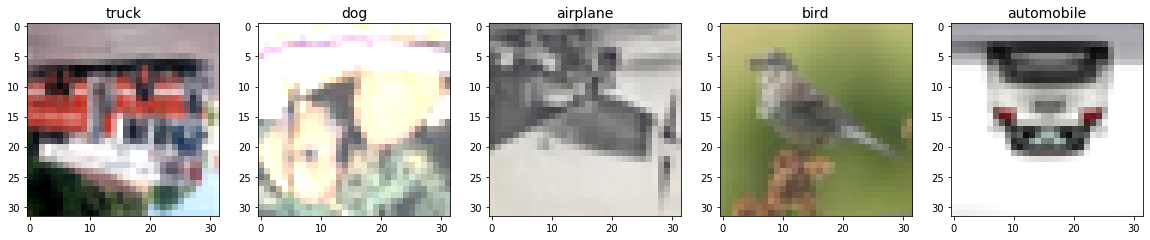

In [5]:
cifar_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cifar_train, info = tfds.load(name='cifar10', split=tfds.Split.TRAIN, as_supervised=True, with_info=True, shuffle_files=False)
cifar_test = tfds.load(name='cifar10', split=tfds.Split.TEST, as_supervised=True, shuffle_files=False)

train_size, test_size = info.splits['train'].num_examples, info.splits['test'].num_examples

cifar_train = cifar_train.map(preprocess_image, num_parallel_calls=8).map(augment, num_parallel_calls=8).shuffle(train_size)
cifar_test = cifar_test.map(preprocess_image, num_parallel_calls=8).shuffle(test_size)

fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(20, 4))
for idx, (img, label) in enumerate(cifar_train.take(5)):
    ax[idx].imshow(img)
    ax[idx].set_title(cifar_names[label], fontsize=14)

In [6]:
class BNConv(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, act, use_bn, **kwargs):
        super().__init__(**kwargs)
        
        self.use_bn = use_bn
        if self.use_bn:
            self.bn = BatchNormalization()
        
        self.conv = Conv2D(filters=filters, kernel_size=kernel_size)
        self.act = act
        
    def build(self, input_shape):
        self.conv.build(input_shape)
        if self.use_bn:
            self.bn.build(self.conv.compute_output_shape(input_shape))
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        x = self.act(x)
        return x
    
    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        return [input_shape[0], input_shape[1]-np.ceil(kernel_size[0]/2), input_shape[2]-np.ceil(kernel_size[1]/2), input_shape[3]]

In [7]:
class BNDense(tf.keras.layers.Layer):
    def __init__(self, units, use_bn, act, **kwargs):
        super().__init__(**kwargs)
        
        self.use_bn = use_bn
        self.units = units
        
        if self.use_bn:
            self.bn = BatchNormalization()
        
        self.dense = Dense(self.units)
        self.act = act
        
    def build(self, input_shape):
        self.dense.build(input_shape)
        if self.use_bn:
            self.bn.build(self.dense.compute_output_shape(input_shape))
        
    def call(self, x):
        x = self.dense(x)
        if self.use_bn:
            x = self.bn(x)
        x = self.act(x)
        return x
    
    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        return [input_shape[0], self.units]

In [9]:
class Cifar10Model(tf.keras.Model):
    def __init__(self, use_bn):
        super().__init__()
        
        self.act = relu
        self.pool = MaxPool2D(pool_size=(2, 2))
        self.global_pool = GlobalMaxPool2D()
        self.flat = Flatten()
        
        self.block1_cfg = [32, 64]
        self.block2_cfg = [64, 128, 256]
        self.block3_cfg = [256]
                
        
        self.ks = (3, 3)
        self.block1 = [BNConv(filters=x, kernel_size=self.ks, act=self.act, use_bn=use_bn) for x in self.block1_cfg]
        self.block2 = [BNConv(filters=x, kernel_size=self.ks, act=self.act, use_bn=use_bn) for x in self.block2_cfg]
        self.block3 = [BNConv(filters=x, kernel_size=self.ks, act=self.act, use_bn=use_bn) for x in self.block3_cfg]
        
        self.blocks = [self.block1, self.block2, self.block3]
        self.pools = [self.pool, self.pool, self.global_pool]
        
        self.fc_cfg = [128, 64]
        self.fc = [BNDense(x, use_bn=use_bn, act=self.act) for x in self.fc_cfg]
        self.softmax_fc = Dense(10, activation=softmax)
        
    def call(self, inputs, training=False):
        x = inputs
        
        for block, pool in zip(self.blocks, self.pools):
            for l in block:
                x = l(x)
            x = pool(x)
        
        x = self.flat(x)
        
        for l in self.fc:
            x = l(x)
        x = self.softmax_fc(x)
            
        return x
        

In [7]:
class LRTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, log_dir, lr=True):  # add other arguments to __init__ if you need
        self.lr = lr
        super().__init__(log_dir=log_dir, profile_batch=0, write_images=True, write_graph=True, histogram_freq=1)

    def on_epoch_end(self, epoch, logs=None):
        if self.lr:
            logs.update({'lr': self.model.optimizer.lr(epoch).numpy()})
        super().on_epoch_end(epoch, logs)

In [10]:
HP_USE_BN = hp.HParam('use_bn', hp.Discrete([True, False]))
HP_LEARNING_RATE = hp.HParam('initial_lr', hp.RealInterval(0.0001, 0.001))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([16, 48, 128]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('tensorboard/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_USE_BN, HP_LEARNING_RATE, HP_BATCH_SIZE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [11]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['acc']

In [19]:
def write_lr(lr_writer, lr_scheduler, steps):
    with lr_writer.as_default():
        for step in np.linspace(0, steps, 1000):
            tf.summary.scalar('learning_rate', lr_scheduler(step), step=step)

In [20]:
tensorboard_root = './tensorboard/cifar10/'
timestampStr = datetime.datetime.now().strftime("%d-%b-%Y--%H:%M")

def train_model(hyper_parameters, run_name, epochs):
    batch_size = hyper_parameters[HP_BATCH_SIZE]
    log_dir = os.path.join(tensorboard_root, f'{timestampStr}__{run_name}')

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=hyper_parameters[HP_LEARNING_RATE],
                                                                 decay_steps=train_size//batch_size*10, decay_rate=0.9, staircase=True)

    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True, write_images=True, histogram_freq=1, profile_batch=0)
    callbacks = [cb_tensorboard]
    
    lr_writer = tf.summary.create_file_writer(os.path.join(tensorboard_root, f'{timestampStr}__{run_name}'))
    write_lr(lr_writer, lr_schedule, train_size//batch_size*epochs)

    model = Cifar10Model(use_bn=hyper_parameters[HP_USE_BN])
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    train_gen = cifar_train.batch(batch_size, drop_remainder=True).prefetch(3).repeat()
    test_gen = cifar_test.batch(batch_size, drop_remainder=True).prefetch(3).repeat()

    logs = model.fit_generator(generator=train_gen, validation_data=test_gen, epochs=epochs,
                        steps_per_epoch=train_size//batch_size, validation_steps=test_size//batch_size, callbacks=callbacks)
    return logs

def run(run_name, hyper_parameters):
    logs = train_model(hyper_parameters, run_name, 10)
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hyper_parameters)  # record the values used in this trial
        best_acc = np.max(logs.history['val_acc'])
        tf.summary.scalar(METRIC_ACCURACY, best_acc, step=1)

In [12]:
session_num = 0

for use_bn in HP_USE_BN.domain.values:
    for lr in tf.linspace(HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value, 3):
        for bs in HP_BATCH_SIZE.domain.values:
            hparams = {
              HP_USE_BN: use_bn,
              HP_LEARNING_RATE: float(lr.numpy()),
              HP_BATCH_SIZE: bs }
            
            
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run(run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'use_bn': False, 'initial_lr': 9.999999747378752e-05, 'batch_size': 16}
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3125/3125 [==============================] - 36s 12ms/step - loss: 1.8907 - acc: 0.2092 - val_loss: 1.6570 - val_acc: 0.3829
Epoch 2/10
3125/3125 [==============================] - 33s 11ms/step - loss: 1.5416 - acc: 0.4075 - val_loss: 1.4501 - val_acc: 0.4575
Epoch 3/10
3125/3125 [==============================] - 33s 11ms/step - loss: 1.3550 - acc: 0.4963 - val_loss: 1.2423 - val_acc: 0.5423
Epoch 4/10
3125/3125 [==============================] - 33s 11ms/step - loss: 1.2342 - acc: 0.5471 - val_loss: 1.1870 - val_acc: 0.5600
Epoch 5/10
3125/3125 [==============================] - 33s 11ms/step - loss: 1.1459 - acc: 0.5851 - val_loss: 1.0534 - val_acc: 0.6215
Epoch 6/10
3125/3125 [==============================] - 34s 11ms/step - loss: 1.0749 - acc: 0.6119 - val_loss: 1.0462 - val_acc: 0.6231
Epoch 7/10
3125/3125 [==============================] - 34s 11ms/step - loss: 1.0127 - acc: 0.6353 - val_loss: 0.9381 - val_acc: 0.6599
Epoch 8/10
3125/3125 [==============================] - 34s

In [21]:
hparams = {
  HP_USE_BN: True,
  HP_LEARNING_RATE: 0.00055000,
  HP_BATCH_SIZE: 16 }

train_model(hparams, 'best_hp', 100)

88888
Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3125/3125 [==============================] - 60s 19ms/step - loss: 1.7903 - acc: 0.2719 - val_loss: 1.7264 - val_acc: 0.3962
Epoch 2/100
3125/3125 [==============================] - 55s 18ms/step - loss: 1.3929 - acc: 0.4822 - val_loss: 1.1913 - val_acc: 0.5728
Epoch 3/100
3125/3125 [==============================] - 55s 18ms/step - loss: 1.2129 - acc: 0.5631 - val_loss: 1.0149 - val_acc: 0.6403
Epoch 4/100
3125/3125 [==============================] - 55s 18ms/step - loss: 1.1048 - acc: 0.6035 - val_loss: 0.9915 - val_acc: 0.6432
Epoch 5/100
3125/3125 [==============================] - 55s 18ms/step - loss: 1.0286 - acc: 0.6349 - val_loss: 0.8926 - val_acc: 0.6856
Epoch 6/100
3125/3125 [==============================] - 55s 18ms/step - loss: 0.9702 - acc: 0.6621 - val_loss: 0.8533 - val_acc: 0.6966
Epoch 7/100
3125/3125 [==============================] - 55s 18ms/step - loss: 0.9198 - acc: 0.6764 - val_loss: 0.8830 - val_acc: 0.6932
Epoch 8/100
3125/3125 [==============================

KeyboardInterrupt: 